In [27]:
try:
    # Comment out if not using colab
    from google.colab import drive
    drive.mount('/content/drive')

    # Specific for luca's computer
    %cd "/content/drive/Othercomputers/Min MacBook Air/INFO381-GitHub"
    using_colab = True
except:
    print("Not using Google Colab")
    using_colab = False

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/Othercomputers/Min MacBook Air/INFO381-GitHub


In [28]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.models as models
import torch.nn as nn

import torch.nn.functional as F

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from torchcam.methods import GradCAM
from torchcam.utils import overlay_mask
from torchvision.transforms.functional import to_pil_image

import os

from utils import get_dataloaders, cherry_pick_img_real, cherry_pick_img_ai_generated


In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [32]:
train_loader, test_loader = get_dataloaders(batch_size=32, split = 'both')
print(test_loader)

Running in Google Colab


In [33]:

cnn_transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor()
])

In [34]:
cnn_model = models.resnet18(pretrained=False)
cnn_model.fc = nn.Linear(cnn_model.fc.in_features, 2)
cnn_model.load_state_dict(torch.load("models/resnet18_cnn.pth", map_location=device))
cnn_model.eval().to(device)
cnn_model.input_size = (512, 512)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [35]:
class_names = ['AI GENERATED', 'REAL']

In [57]:
def generate_gradcam(image_path, model, transform, class_names):
    img = Image.open(image_path).convert("RGB")
    input_tensor = transform(img).unsqueeze(0)

    cam_extractor = GradCAM(model, target_layer="layer4")

    output = model(input_tensor)
    probs = F.softmax(output, dim=1)
    predicted_class = torch.argmax(probs, dim=1).item()

    print(f"📊 Prediction: {class_names[predicted_class]} (class {predicted_class})")

    activation_map = cam_extractor(predicted_class, output)

    img_resized = img.resize((512, 512))
    heatmap = to_pil_image(activation_map[0], mode='F')
    result = overlay_mask(img_resized, heatmap, alpha=0.5)

    # ✅ Dette trengs
    return img_resized, result, class_names[predicted_class]



In [58]:
import os
os.makedirs("gui_images/GRADCAM/real/", exist_ok=True)
os.makedirs("gui_images/GRADCAM/ai_generated/", exist_ok=True)

In [59]:
img_path_real_one = cherry_pick_img_real[1]
img_path_real_two = cherry_pick_img_real[2]

img_path_ai_one = cherry_pick_img_ai_generated[1]
img_path_ai_two = cherry_pick_img_ai_generated[2]

In [74]:
def show_side_by_side_from_paths(original_path, gradcam_image, title="CNN + Grad-CAM", filename=None):
    original_img = Image.open(original_path).convert("RGB").resize((512, 512))

    gradcam_image = gradcam_image.resize((512, 512))

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    axes[0].imshow(original_img)
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    axes[1].imshow(gradcam_image)
    axes[1].set_title(title)
    axes[1].axis("off")

    plt.tight_layout()

    plt.show()

📊 Prediction: REAL (class 1)


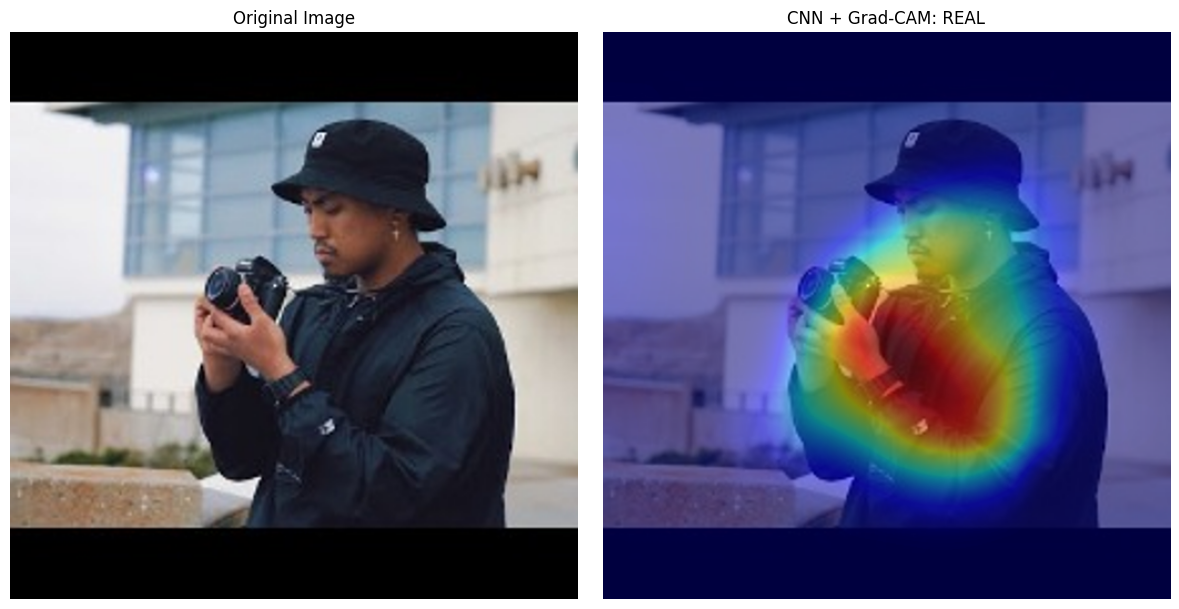

In [75]:
_, gradcam_img, predicted_label = generate_gradcam(
    image_path=img_path_real_one,
    model=cnn_model,
    transform=cnn_transform,
    class_names=class_names
)

show_side_by_side_from_paths(
    original_path=img_path_real_one,
    gradcam_image=gradcam_img,
    title=f"CNN + Grad-CAM: {predicted_label.upper()}",
)

📊 Prediction: REAL (class 1)


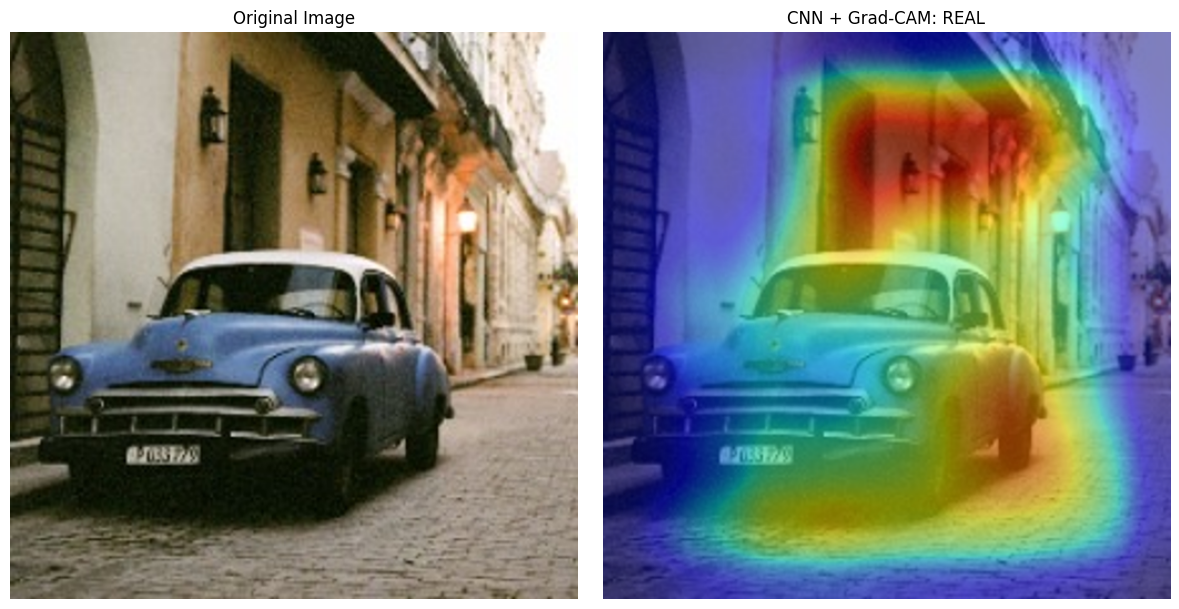

In [76]:
_, gradcam_img, predicted_label = generate_gradcam(
    image_path=img_path_real_two,
    model=cnn_model,
    transform=cnn_transform,
    class_names=class_names
)

show_side_by_side_from_paths(
    original_path=img_path_real_two,
    gradcam_image=gradcam_img,
    title=f"CNN + Grad-CAM: {predicted_label.upper()}",
)

📊 Prediction: AI GENERATED (class 0)


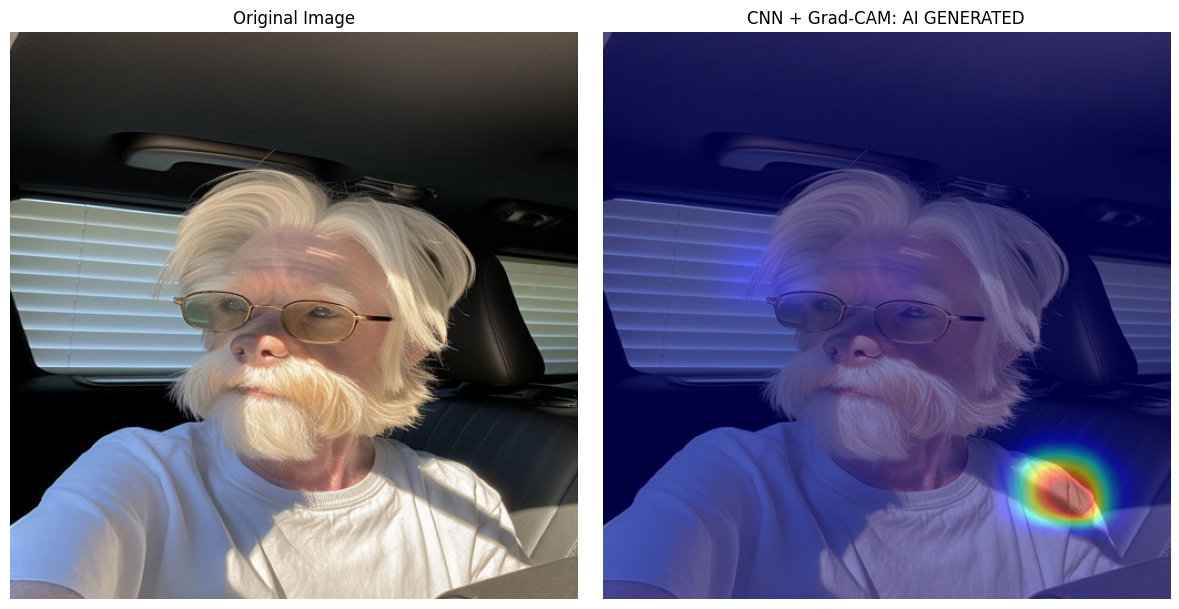

In [77]:
_, gradcam_img, predicted_label = generate_gradcam(
    image_path=img_path_ai_one,
    model=cnn_model,
    transform=cnn_transform,
    class_names=class_names
)

show_side_by_side_from_paths(
    original_path=img_path_ai_one,
    gradcam_image=gradcam_img,
    title=f"CNN + Grad-CAM: {predicted_label.upper()}",
)

📊 Prediction: REAL (class 1)


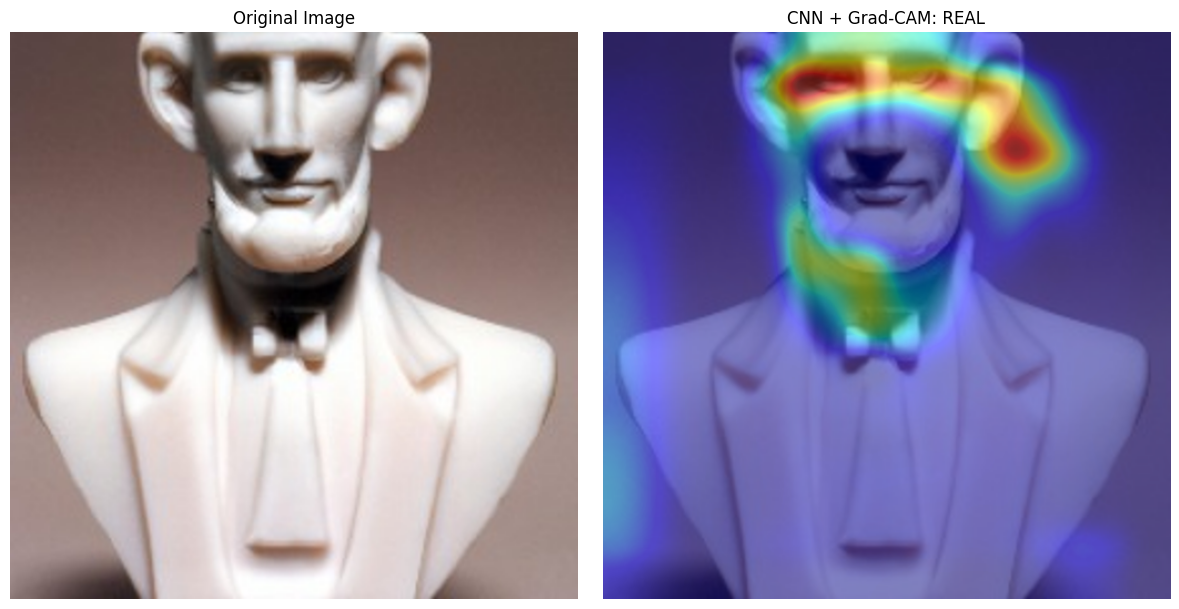

In [78]:
_, gradcam_img, predicted_label = generate_gradcam(
    image_path=img_path_ai_two,
    model=cnn_model,
    transform=cnn_transform,
    class_names=class_names
)

show_side_by_side_from_paths(
    original_path=img_path_ai_two,
    gradcam_image=gradcam_img,
    title=f"CNN + Grad-CAM: {predicted_label.upper()}",
)